# Generate heatmaps by building block

For a specified building block, generate the heatmap spanning all other building blocks it has been tried with.

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.analysis.heatmapfromdb import normalize_yields, get_plot
from src.util.db_utils import SynFermDatabaseConnection
from src.util.utils import get_conf
con = SynFermDatabaseConnection()
conf = get_conf()

In [2]:
BUILDING_BLOCK = "TerABT007"

In [3]:
exps = con.get_experiments_with_buildingblock(BUILDING_BLOCK)

In [4]:
header = [
 'exp_nr',
 'plate_nr',
 'well',
 'lab_journal_number',
 'initiator',
 'monomer',
 'terminator',
 'product_A_lcms_ratio',
 'product_B_lcms_ratio',
 'product_C_lcms_ratio',
 'product_D_lcms_ratio',
 'product_E_lcms_ratio',
 'product_F_lcms_ratio',
 'product_G_lcms_ratio',
 'product_H_lcms_ratio',
 'vl_id',
 'valid'
]

df = pd.DataFrame(data=exps, columns=header)

In [7]:
# filter invalid stuff
df = df.loc[df["exp_nr"].between(4, 29) & (~df["valid"].str.contains("ERROR", na=False))]
# normalize
yields = normalize_yields(df, conf["heatmap"]["normalization_constant"])

In [8]:
# get rid of duplicates (some syntheses have been done in duplicate)
yields = yields.groupby(["initiator", "monomer", "terminator"]).mean(numeric_only=True).reset_index()

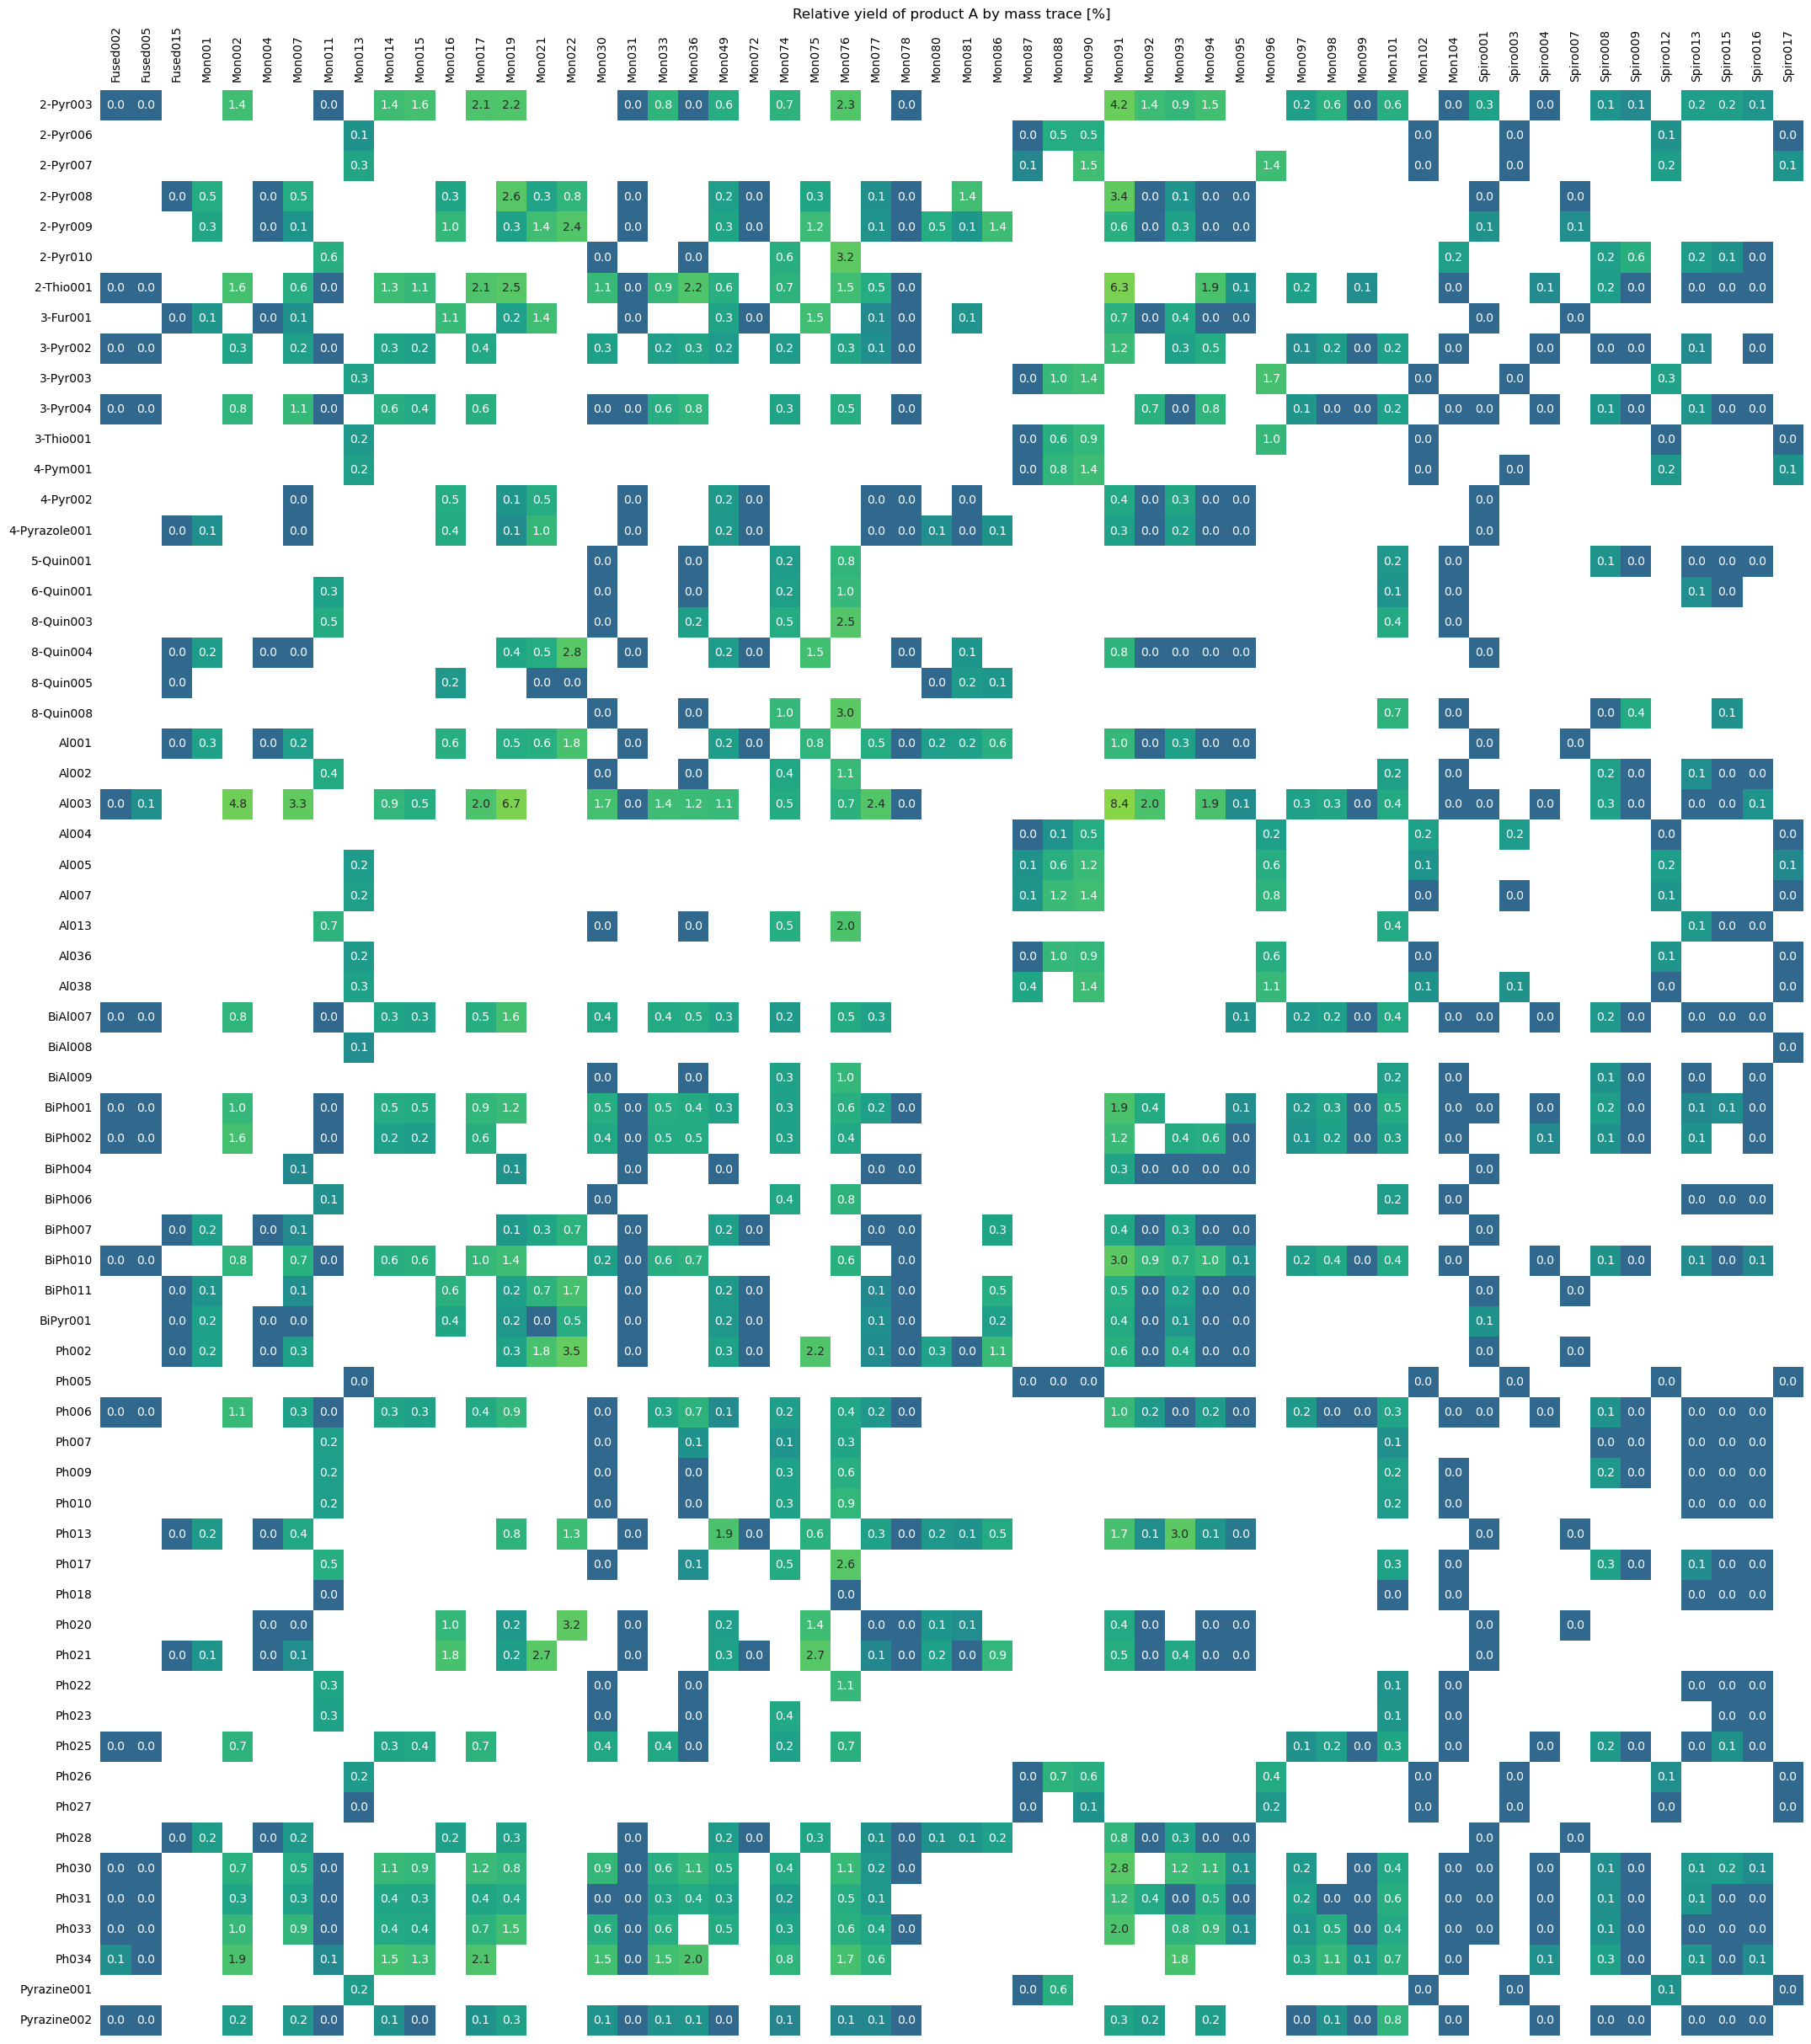

In [22]:
# set product type to plot
product_type = 'A'

# plot
fig, ax = plt.subplots(figsize=(30,30))
if BUILDING_BLOCK.startswith("I"):
    plot_df = yields[['terminator', 'monomer', f'product_{product_type}_lcms_ratio']] \
        .pivot(columns='terminator', index='monomer', values=f'product_{product_type}_lcms_ratio')
elif BUILDING_BLOCK.startswith("M"):
    plot_df = yields[['terminator', 'initiator', f'product_{product_type}_lcms_ratio']] \
        .pivot(columns='terminator', index='initiator', values=f'product_{product_type}_lcms_ratio')
elif BUILDING_BLOCK.startswith("T"):
    plot_df = yields[['monomer', 'initiator', f'product_{product_type}_lcms_ratio']] \
        .pivot(columns='monomer', index='initiator', values=f'product_{product_type}_lcms_ratio') + 1e-4
#plot_df = sort_by_sparsity(plot_df)
#plot_df = sort_by_sparsity(plot_df, axis=1)
plot_df = plot_df#.sort_index(axis=0, key=alphanumeric_index_sort)
plot_df = plot_df#.sort_index(axis=1, key=alphanumeric_index_sort)
# plot the heatmap
ax = get_plot(plot_df, product_type, ax=ax, norm=LogNorm(vmin=1e-4, vmax=100))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()